# Module 6: Generalization Performance 

* Consider our original regression dataset in the Figure below

* We can fit simple polynomial functions with various degrees to this dataset. We'll pick degree = 1 (blue), 5 (purple), and 15 (magenta).

* The higher the degree of the polynomial, the more parameters, and hence, the more complex the model

![alt text](figures/generalization_training.png)


* Clearly, as the degree increases, the MSE on the dataset decreases.

* But, look at what happens when we measure MSE on data points the model has not been trained on:

![alt text](figures/generalization_testing.png)

* The most complex model has the worst MSE on unseen data, despite having the best MSE on the training data

* We say that the model has _overfitted_ to the training dataset: it mistook noise for an actual signal.

* This is why we _must_ evaluate our models on data the model has not been trained on

* Before we do that, lets see how our neural network models can overfit




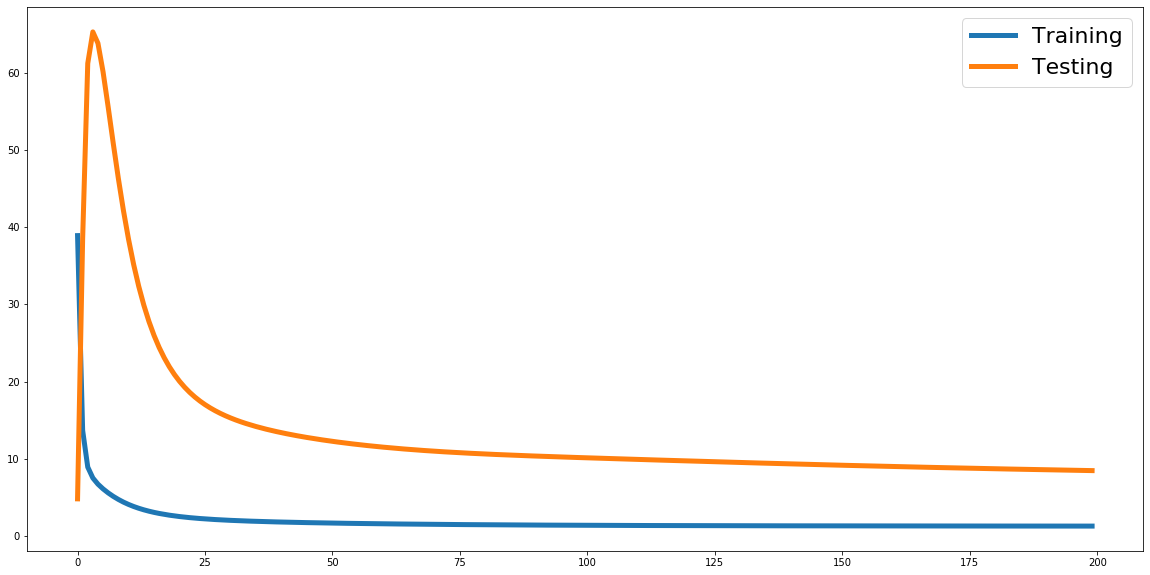

In [20]:
import numpy as np
import numpy.random as rng 
import tensorflow as tf
import matplotlib.pyplot as plt 
# try varying the number of hidden units and learning rates
n_hidden = 50
eta = 0.01

# read data
data = np.load('code/day2/fake_data.npz')
X, y = data['X'], data['y']

# split data into training and testing
Xtrain = X[:20, :]
ytrain = y[:20, :]
Xtest = X[20:,:]
ytest = y[20:,:]

# move data to tensorflow space
Xtrain = tf.convert_to_tensor(Xtrain, dtype=tf.float32)
ytrain = tf.convert_to_tensor(ytrain, dtype=tf.float32)
Xtest = tf.convert_to_tensor(Xtest, dtype=tf.float32)
ytest = tf.convert_to_tensor(ytest, dtype=tf.float32)

# randomly initialize model parameters
W_input_hidden = tf.Variable(rng.randn(X.shape[1], n_hidden), dtype=tf.float32) 
W_hidden_output = tf.Variable(rng.randn(n_hidden, 1), dtype=tf.float32)
b_hidden = tf.Variable(rng.randn(n_hidden), dtype=tf.float32)
b_output = tf.Variable(rng.randn(1), dtype=tf.float32)
variables = [W_input_hidden, W_hidden_output, b_hidden, b_output]

# create optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)

# repeat N times
N = 200
train_mse = []
test_mse = []
for i in range(N):
    
    with tf.GradientTape() as gt:
        
        # training loss
        hidden_activation = tf.t(b_hidden + tf.matmul(Xtrain, W_input_hidden))
        ypred = b_output + tf.matmul(hidden_activation, W_hidden_output)
        train_mse_loss = tf.reduce_mean(tf.square(ypred - ytrain))
        
    
    train_mse.append(train_mse_loss.numpy())
    
    # test loss
    hidden_activation = tf.tanh(b_hidden + tf.matmul(Xtest, W_input_hidden))
    ypred = b_output + tf.matmul(hidden_activation, W_hidden_output)
    mse_loss = tf.reduce_mean(tf.square(ypred - ytest))
    test_mse.append(mse_loss.numpy())
    
    
    # compute gradient of loss with respect to parameters
    # calculus NOT required!
    gradients = gt.gradient(train_mse_loss, variables)
    
    # update the parameters
    # this takes a list where each element is a tuple
    # of (gradient, corresponding parameter)
    optimizer.apply_gradients(zip(gradients, variables))
    
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(np.arange(N), train_mse, label='Training', linewidth=5)
ax.plot(np.arange(N), test_mse, label='Testing', linewidth=5)
ax.legend(fontsize=22)
